# ADS Project 3 Group 4

## Libraries and Settings

In [1]:
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image

In [2]:
"""
Path
"""
DATA_PATH = "../data/train_set"
IMAGE_FOLDER = os.path.join(DATA_PATH, "images")
POINTS_FOLDER = os.path.join(DATA_PATH, "points")
LABELS_FOLDER = DATA_PATH

## Read Training Data

In [3]:
def read_all_images():
    """
    Read 2500 training images from the IMAGE_FOLDER
    :return a 4d numpy array in form of (index, height, width, channels), channels is RGB 
    """
    files = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith('.jpg')]
    files.sort()
    
    face_images = np.zeros((len(files), 750, 1000, 3))
    
    for index, filename in enumerate(files):
        face_img_arr = plt.imread(os.path.join(IMAGE_FOLDER, filename))
        if face_img_arr.shape != (750,1000,3):
            # resize the image
            face_img = Image.fromarray(face_img_arr)
            face_img = face_img.resize((1000,750))
            face_img_arr = np.array(face_img)
        face_images[index] = face_img_arr
    return face_images

def read_labels():
    """
    Read the image labels from the label.csv file
    :return a pandas.DataFrame with 3 columns: 'emotion_idx','emotion_cat','type'
    """
    labels_df = pd.read_csv(os.path.join(LABELS_FOLDER, 'label.csv'))
    labels_df = labels_df.loc[:,['emotion_idx','emotion_cat','type']]
    return labels_df
    

def read_all_points():
    """
    Read all face coordinates points
    :return a tuple of shape (2500, 78, 2). Because for each of 2500 images there are 78 points associated with it
    """
    files = [file for file in os.listdir(POINTS_FOLDER) if file.endswith('.mat')]
    files.sort()
    
    face_points = np.zeros((len(files), 78, 2))
    for index, filename in enumerate(files):
        face_points_dict = loadmat(os.path.join(POINTS_FOLDER, filename))
    
        face_points[index] = face_points_dict.get('faceCoordinatesUnwarped',  face_points_dict.get('faceCoordinates2'))
    return face_points

def load_data(loadImage = False):
    """
    Load training data from local files
    
    :loadImage if it's False, this function will not load original images
    :return a tuple (images, points, labels)
        if loadImage is False, the 'images' will None. Otherwise its a numpy array with shape (2500,750,1000,3)
        points is a numpy array with shape (2500, 78, 2)
        labels is a pandas.DataFrame
    """
    #face_images_narr =  read_all_images() if loadImage else None
    face_images_points = read_all_points()
    labels = read_labels()
    #return face_images_narr, face_images_points, labels
    return face_images_points, labels

In [4]:
# pass True if you want to read original images, it might take some time to do it
#images, points, labels = load_data(True)
points, labels = load_data(True)

In [5]:
#if images:
#    print(images.shape)

print(points.shape)
labels

(2500, 78, 2)


,emotion_idx,emotion_cat,type
0,1,Neutral,simple
1,1,Neutral,simple
2,1,Neutral,simple
3,1,Neutral,simple
4,1,Neutral,simple
...,...,...,...
2495,22,Sadly disgusted,compound
2496,22,Sadly disgusted,compound
2497,22,Sadly disgusted,compound
2498,22,Sadly disgusted,compound


In [8]:
from sklearn.metrics import pairwise_distances

def feature(input_points):
    n = input_points.shape[0]
    pairwise_dist_data = []
    # return a vector
    def pairwise_dist(vec):
        vec = np.reshape(vec, (len(vec),1))
        dist_matrix = pairwise_distances(vec)
        dist_matrix = dist_matrix[np.triu_indices(dist_matrix.shape[0], k=1)]
        return dist_matrix
    
    # dist is an 2 column array
    def pairwise_dist_result(mat):
        dist = np.apply_along_axis(func1d=pairwise_dist, axis=0, arr=mat)
        dist_result = np.ndarray.flatten(dist,order='F').tolist()
        return dist_result
    
    for i in range(n):
        pairwise_dist_feature = pairwise_dist_result(points[i,:,:])
        pairwise_dist_data.append(pairwise_dist_feature)
        
    pairwise_dist_data = pd.DataFrame(pairwise_dist_data)
    return pairwise_dist_data
        


In [11]:
X = feature(points)
y = labels['emotion_idx']

0        1
1        1
2        1
3        1
4        1
        ..
2495    22
2496    22
2497    22
2498    22
2499    22
Name: emotion_idx, Length: 2500, dtype: int64


In [15]:
from sklearn.model_selection import train_test_split
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

286      3
1495    14
40       1
1106    10
1379    13
        ..
1033     9
1731    16
763      7
835      8
1653    15
Name: emotion_idx, Length: 2000, dtype: int64

In [25]:
# model selection with cross-validation 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
k_range = range(1,31)
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)

[0.16539042687571937, 0.18896920690311275, 0.1930451632581956, 0.20352750789991997, 0.2100487735012732, 0.21456889268655277, 0.2260104530637992, 0.24153722221925827, 0.24351734243066234, 0.24856563818397967, 0.25793576036962385, 0.25792206531103357, 0.2588973352981191, 0.25286451535282695, 0.2533865199823715, 0.2529690873935023, 0.25299995723608604, 0.2555308520613006, 0.25805868573945673, 0.2594833097084706, 0.2574377499083251, 0.25691828451389476, 0.25242931708606575, 0.2559588092832744, 0.25589308908009717, 0.2514308787973179, 0.25379251197026065, 0.25379413183442345, 0.2493731147054113, 0.2508913080300431]


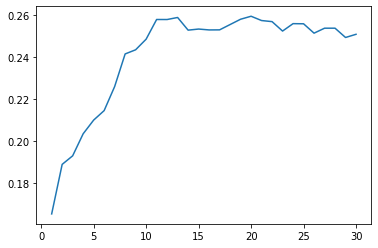

In [26]:
plt.plot(k_range, cv_scores)

In [32]:
from sklearn.metrics import accuracy_score
k_best = cv_scores.index(max(cv_scores))
knn_best = KNeighborsClassifier(n_neighbors=k_best)
knn_best.fit(X_train, y_train)
pred = knn_best.predict(X_test)
print("accuracy: {}".format(accuracy_score(y_test, pred)))

accuracy: 0.268
